In [1]:
import tensorflow as tf
import gym, random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env = gym.make("CartPole-v1")

In [3]:
env.action_space, env.observation_space, env.reward_range

(Discrete(2), Box(4,), (-inf, inf))

In [4]:
env.action_space.shape

()

In [5]:
env.observation_space.shape

(4,)

In [6]:
reshape_state = lambda state: state.reshape(1, env.observation_space.shape[0])
def take_step(action):
    new_state, reward, done, info = env.step(action)
    return reshape_state(new_state), reward, done, info

In [7]:
state_in = tf.keras.layers.Input(env.observation_space.shape, name="state_in")

x = tf.keras.layers.Dense(8, activation="relu")(state_in)
# x = tf.keras.layers.Dense(8, activation="relu")(x)
x = tf.keras.layers.Dense(env.action_space.n, activation="linear")(x)

policy = tf.keras.models.Model([state_in], x)

optimizer = tf.keras.optimizers.Adam(lr=0.1)
policy.compile(optimizer=optimizer, loss="mse")

In [8]:
state_in = tf.keras.layers.Input(env.observation_space.shape, name="state_in")

x = tf.keras.layers.Dense(8, activation="relu")(state_in)
# x = tf.keras.layers.Dense(8, activation="relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

value = tf.keras.models.Model([state_in], x)

optimizer = tf.keras.optimizers.Adam(lr=0.1)
value.compile(optimizer=optimizer, loss="mse")

In [9]:
def update_value(value, state, td_target):
    value.optimizer.lr = 0.01
    value.fit(state, td_target, epochs=1, verbose=0)

In [10]:
def update_policy(policy, delta, state, action):
    predictions = policy.predict(state)
    
    for row in range(len(action)):
        predictions[row, action] = delta
    
    policy.optimizer.lr = 0.01
    policy.fit(state, predictions, epochs=1, verbose=0)

In [11]:
def n_to_onehot(action):
    zeros = np.zeros(env.action_space.n, dtype=np.float32)
    zeros[action] = 1.
    return zeros.reshape(1, env.action_space.n)

In [12]:
def value_replay_to_numpy(value_samples):
    states, td_targets = [] , []
    for state, td_target in value_samples:
        states.append(state)
        td_targets.append(td_target)
    
    states = np.array(states).reshape(len(states), env.observation_space.shape[0])
    td_targets = np.array(td_targets).reshape(len(td_targets), 1)
    return states, td_targets

def policy_replay_to_numpy(policy_samples):
    deltas, states, actions = [] , [], []
    for delta, state, action in policy_samples:
        deltas.append(delta)
        states.append(state)
        actions.append(action)
    
    deltas = np.array(deltas).reshape(len(deltas), 1)
    states = np.array(states).reshape(len(states), env.observation_space.shape[0])
    actions = np.array(actions).reshape(len(actions), 1)
    return deltas, states, actions

In [13]:
from collections import deque
value_replay = deque([], 5000)
policy_replay = deque([], 5000)

In [14]:
def run(gamma=0.9, render=False, replay_size=100):
    # reset
    I = 1
    lr_value = lr_policy = 0.01
    step = 0
    initial_state = state = reshape_state(env.reset())

    while True:
        if render: env.render()
            
        # choose action
        action_probs = policy.predict(state)[0]
        e_x = np.exp(action_probs - np.max(action_probs))
        softmax_probs = e_x / e_x.sum()
        action = np.random.choice(range(env.action_space.n), p=softmax_probs)
    
        # take action
        new_state, reward, done, _ = take_step(action)

        # calculate td error
        if done:
            td_target = np.array([reward], dtype=np.float32)
        else:
            td_target = reward + gamma * value.predict([new_state])[0]
            
        delta = td_target - value.predict(state)[0]
        
        # update value weights
        value_replay.append((state, td_target))
        update_value(value, [state], [td_target])
        
        # update policy weights
        policy_replay.append((delta, state, action))
        update_policy(policy, delta, [state], [action])
        
        if done:
            value_samples = random.sample(value_replay, min(len(value_replay), replay_size))
            states, td_targets = value_replay_to_numpy(value_samples)
            update_value(value, states, td_targets)
            
            policy_samples = random.sample(policy_replay, min(len(policy_replay), replay_size))
            deltas, states, actions = policy_replay_to_numpy(policy_samples)
            update_policy(policy, deltas, states, actions)
            
            break

        # update algorithm vars
        # gamma = gamma * gamma
        state = new_state
        step += 1
        if step > 500:
            break
    
    return step

99.23 8.0


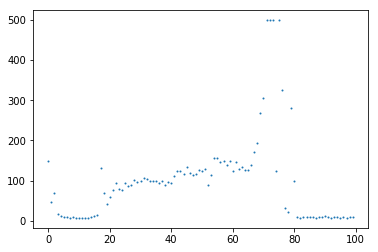

In [22]:
steps = [run(gamma=1, render=False, replay_size=100) for i in range(100)]
print(np.mean(steps), np.percentile(steps, 10))
plt.scatter(range(len(steps)), steps, s=1)
plt.show()

In [36]:
env.close()